In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import sys
import glob
import re
import pickle
import random

import wave
import librosa as lb
import librosa.display as lbd
from python_speech_features import *
import soundfile as sf
import io
from IPython.display import Audio

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import ast

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Embedding, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

from sklearn.model_selection import train_test_split

2025-07-27 02:12:06.781648: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 02:12:06.782747: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 02:12:06.788165: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 02:12:06.796979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753562526.815087  161069 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753562526.81

cpu


In [2]:
df = pd.read_csv('audio_features.csv')
df_b = pd.read_csv('audio_balanced.csv')
df_77 = pd.read_csv('audio_balanced_77.csv')
train_df_balanced = pd.read_csv('train_balanced.csv')
test_df_balanced = pd.read_csv('test_balanced.csv')
df_bdown = pd.read_csv('audio_balanced_downsampled.csv')
train_df_bdown = pd.read_csv('train_balanced_downsampled.csv')
test_df_bdown = pd.read_csv('test_balanced_downsampled.csv')

# print table for sizes of df, df_balanced, df_balanced_downsampled, df_77, train_df_balanced, test_df_balanced, train_df_bdown, test_df_bdown
sizes_table = pd.DataFrame({
    'DataFrame': ['df', 'df_balanced', 'df_balanced_downsampled', 'df_77', 'train_df_balanced', 'test_df_balanced', 'train_df_bdown', 'test_df_bdown'],
    'No. of Samples': [len(df), len(df_b), len(df_bdown), len(df_77), len(train_df_balanced), len(test_df_balanced), len(train_df_bdown), len(test_df_bdown)]
})

sizes_table = sizes_table.set_index('DataFrame')
sizes_table = sizes_table.reset_index()
sizes_table = sizes_table.style.set_properties(**{'text-align': 'left'})
sizes_table = sizes_table.set_table_attributes('class="table table-striped"')
sizes_table = sizes_table.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
sizes_table

,DataFrame,No. of Samples
0,df,196
1,df_balanced,306
2,df_balanced_downsampled,86
3,df_77,154
4,train_df_balanced,232
5,test_df_balanced,74
6,train_df_bdown,64
7,test_df_bdown,22


In [3]:
def get_train_test_split(df, val, reshape_val):
    ''' 
    df is a DataFrame with a 'Features' column containing string representations of numpy arrays.
    val is the test size for train_test_split.
    resshape val is like (-1, 1, 256) or (-1, 256) depending on the model input shape. thus it is a tuple.
    '''
    if type(df['Features'].iloc[0]) == str:
        df['Features'] = df['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
        
    X = np.stack(df['Features'].values)
    print("X shape before reshape:", X.shape)
    X = X.reshape(reshape_val)
    y = df['PHQ_Binary'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val, random_state=44)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    print("Train and Test Split:" f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")
    return X_train, X_test, y_train, y_test
    
    

In [4]:
if type(df_b['Features'].iloc[0]) == str:
    df_b['Features'] = df_b['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
X = np.stack(df_b['Features'].values)
print("X shape before reshape:", X.shape)
X = X.reshape(-1, 1, 256)
y = df_b['PHQ_Binary'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=44)
print("Train and Test Split for Balanced:" f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

X shape before reshape: (306, 256)
Train and Test Split for Balanced:(244, 1, 256), (62, 1, 256), (244,), (62,)


In [5]:
X_train77, X_test77, y_train77, y_test77 = get_train_test_split(df_77, 0.2, (-1, 1, 256))
X_trainD, X_testD, y_trainD, y_testD = get_train_test_split(df_bdown, 0.2, (-1, 1, 256))

X shape before reshape: (154, 256)
Train and Test Split:(123, 1, 256), (31, 1, 256), (123,), (31,)
X shape before reshape: (86, 256)
Train and Test Split:(68, 1, 256), (18, 1, 256), (68,), (18,)


In [6]:
# evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")    
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    

In [7]:
# plot graph of accuracy and loss over time in same figure
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Accuracy and Loss')
    plt.xlabel('Epochs')

### GRU 32, 16, (1, 256), None

In [8]:
model = Sequential()
model.add(GRU(32, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-07-27 02:12:12.254598: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,385 (110.88 KB)

 Trainable params: 28,385 (110.88 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs = [10, 50, 100]

#### 1. Upsampled Balanced Dataset 

Training for 10 epochs
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.4265 - loss: 0.7220 - val_accuracy: 0.5484 - val_loss: 0.6955
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5711 - loss: 0.6747 - val_accuracy: 0.5968 - val_loss: 0.6820
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6336 - loss: 0.6549 - val_accuracy: 0.5968 - val_loss: 0.6688
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7327 - loss: 0.6275 - val_accuracy: 0.6129 - val_loss: 0.6572
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6800 - loss: 0.6176 - val_accuracy: 0.5968 - val_loss: 0.6460
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7080 - loss: 0.5948 - val_accuracy: 0.6452 - val_loss: 0.6333
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7956 - loss: 0.5690 - val_accuracy: 0.6452 - val_loss: 0.6203
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8126 - loss: 0.5654 - val_accuracy: 0.6

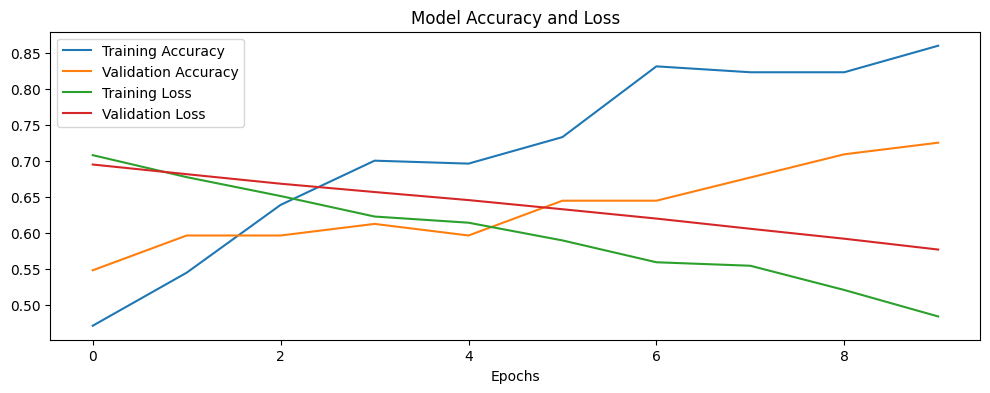

Training for 50 epochs
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4709 - loss: 0.7101 - val_accuracy: 0.5323 - val_loss: 0.6929
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5352 - loss: 0.6748 - val_accuracy: 0.5645 - val_loss: 0.6818
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5639 - loss: 0.6635 - val_accuracy: 0.5484 - val_loss: 0.6714
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6318 - loss: 0.6336 - val_accuracy: 0.5968 - val_loss: 0.6598
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7450 - loss: 0.5921 - val_accuracy: 0.5968 - val_loss: 0.6488
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7395 - loss: 0.5944 - val_accuracy: 0.5968 - val_loss: 0.6368
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7357 - loss: 0.5881 - val_accuracy: 0.6129 - val_loss: 0.6243
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7682 - loss: 0.5638 - val_accuracy: 0.6

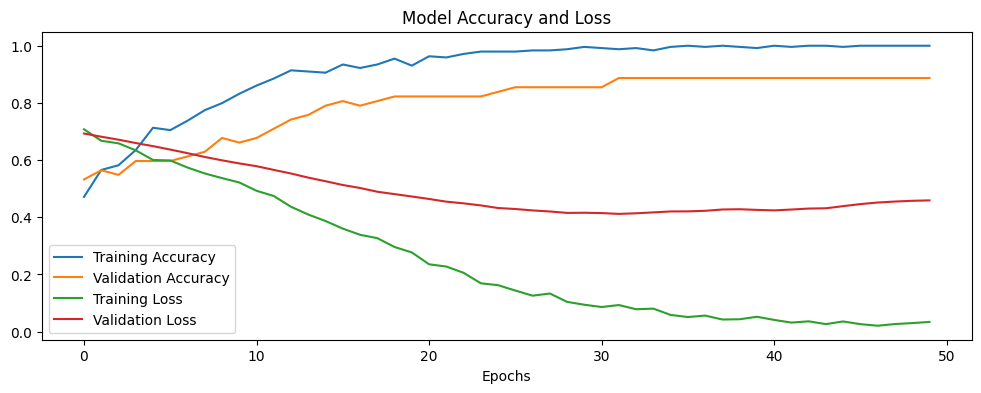

Training for 100 epochs
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4940 - loss: 0.7021 - val_accuracy: 0.6129 - val_loss: 0.6800
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5372 - loss: 0.6808 - val_accuracy: 0.7419 - val_loss: 0.6720
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5832 - loss: 0.6721 - val_accuracy: 0.7903 - val_loss: 0.6665
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7108 - loss: 0.6587 - val_accuracy: 0.7903 - val_loss: 0.6606
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8086 - loss: 0.6263 - val_accuracy: 0.8226 - val_loss: 0.6539
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7749 - loss: 0.6271 - val_accuracy: 0.8226 - val_loss: 0.6479
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7844 - loss: 0.6215 - val_accuracy: 0.8065 - val_loss: 0.6408
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8506 - loss: 0.6003 - val_accu

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7b76d0794ae0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Accuracy: 0.8710
Precision: 0.7895
Recall: 1.0000
F1 Score: 0.8824


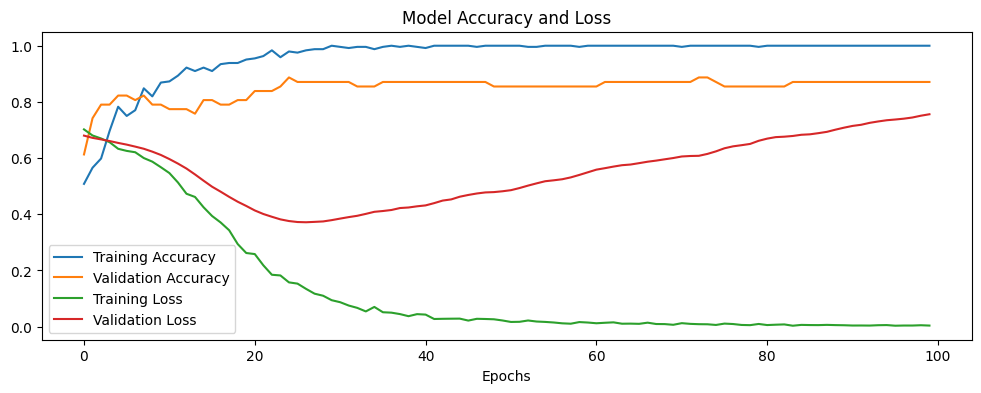

In [10]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    model = Sequential()
    model.add(GRU(32, input_shape=(1, 256), return_sequences=False))  # single time step
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_test, y_test))
    evaluate_model(model, X_test, y_test)
    
    # Plot the training history
    plot_history(history)
    plt.show()
    
    model.save(f'saved_models/gru_model_{epoch}_32_16_1256.h5')

#### 2. 77 of each class

Training for 10 epochs
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9953 - loss: 0.0097 - val_accuracy: 0.8710 - val_loss: 0.7673
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.8710 - val_loss: 0.7774
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8548 - val_loss: 0.7944
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.8548 - val_loss: 0.7972
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.8710 - val_loss: 0.7978
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.8710 - val_loss: 0.8027
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.8710 - val_loss: 0.8117
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.8

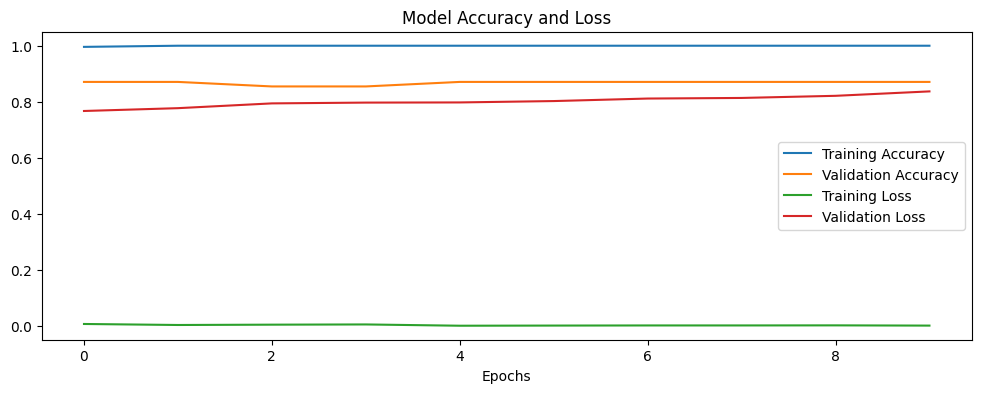

Training for 50 epochs
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.8710 - val_loss: 0.8386
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8710 - val_loss: 0.8515
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8710 - val_loss: 0.8688
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 7.6715e-04 - val_accuracy: 0.8710 - val_loss: 0.8883
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8710 - val_loss: 0.9130
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8710 - val_loss: 0.9236
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8710 - val_loss: 0.9459
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy:

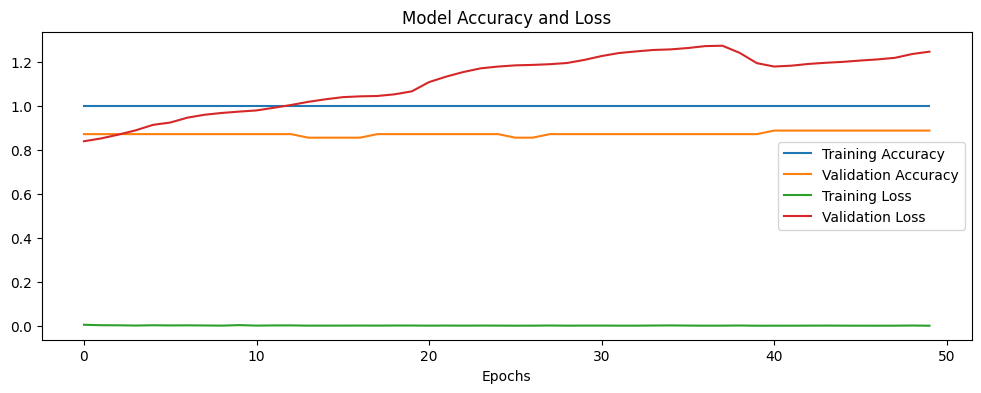

Training for 100 epochs
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 1.0000 - loss: 5.0396e-04 - val_accuracy: 0.8710 - val_loss: 1.2828
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.1863e-04 - val_accuracy: 0.8710 - val_loss: 1.2950
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.0817e-04 - val_accuracy: 0.8871 - val_loss: 1.3140
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8871 - val_loss: 1.3022
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9936 - loss: 0.0056 - val_accuracy: 0.8871 - val_loss: 1.2888
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.9103e-05 - val_accuracy: 0.8871 - val_loss: 1.2842
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 1.0153e-04 - val_accuracy: 0.8871 - val_loss: 1.2827
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - los

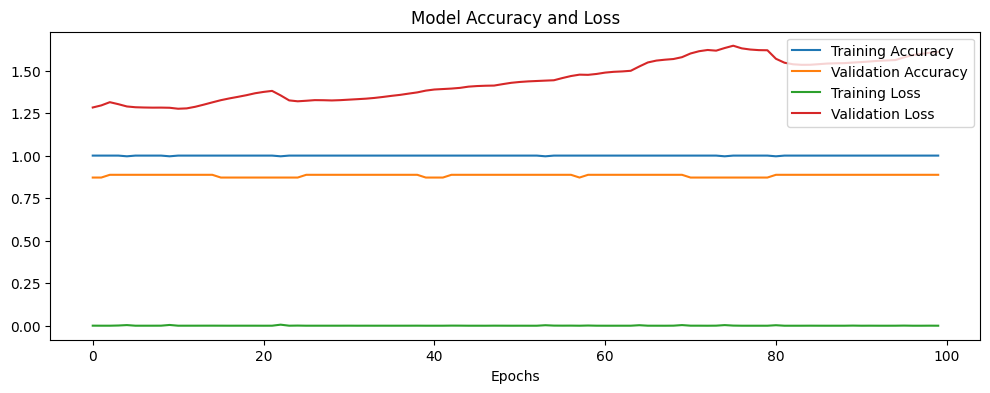

In [11]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_test, y_test))
    
    # Evaluate the model
    evaluate_model(model, X_test, y_test)
    
    # Plot the training history
    plot_history(history)
    plt.show()
    
    # Save the model
    model.save(f'saved_models/gru_model_{epoch}_epochs.h5')

#### 3. Downsampled Balanced Dataset

Training for 10 epochs
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 4.5404e-04 - val_accuracy: 0.8871 - val_loss: 1.6138
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 2.6001e-05 - val_accuracy: 0.8871 - val_loss: 1.6171
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 3.1263e-05 - val_accuracy: 0.8871 - val_loss: 1.6188
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.5460e-04 - val_accuracy: 0.8871 - val_loss: 1.6219
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 7.9697e-05 - val_accuracy: 0.8871 - val_loss: 1.6270
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 6.3603e-05 - val_accuracy: 0.8871 - val_loss: 1.6324
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 1.4516e-04 - val_accuracy: 0.8871 - val_loss: 1.6354
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss

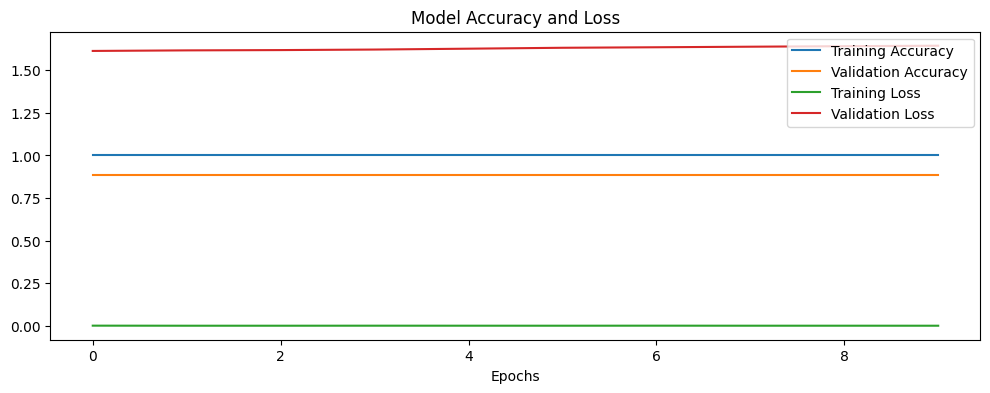

Training for 50 epochs
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 7.3454e-05 - val_accuracy: 0.8871 - val_loss: 1.6469
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 3.6835e-05 - val_accuracy: 0.8871 - val_loss: 1.6486
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 1.7573e-04 - val_accuracy: 0.8871 - val_loss: 1.6518
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.8871 - val_loss: 1.6443
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.2180e-04 - val_accuracy: 0.8871 - val_loss: 1.6431
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.8254e-04 - val_accuracy: 0.8871 - val_loss: 1.6445
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 1.9665e-04 - val_accuracy: 0.8871 - val_loss: 1.6483
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 8.

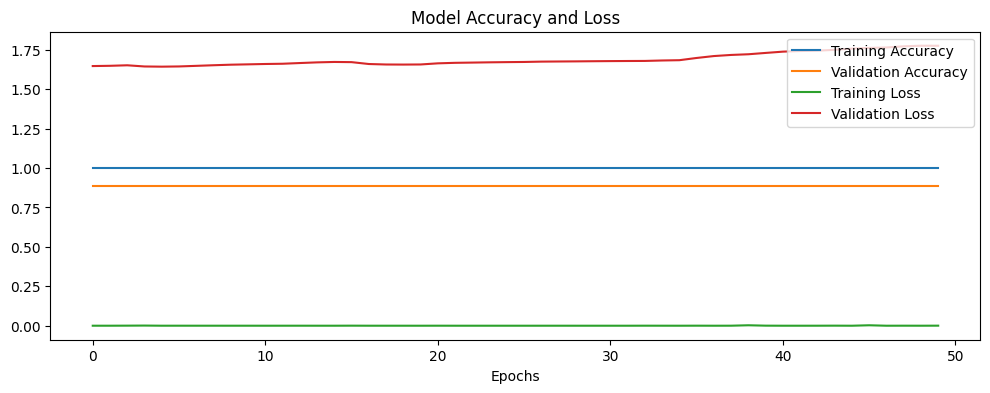

Training for 100 epochs
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 3.4588e-05 - val_accuracy: 0.8871 - val_loss: 1.7756
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 8.8581e-05 - val_accuracy: 0.8871 - val_loss: 1.7778
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 7.9812e-05 - val_accuracy: 0.8871 - val_loss: 1.7820
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.3855e-06 - val_accuracy: 0.8871 - val_loss: 1.7873
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 5.8921e-05 - val_accuracy: 0.8871 - val_loss: 1.7905
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 4.0544e-06 - val_accuracy: 0.8871 - val_loss: 1.7920
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.0397e-04 - val_accuracy: 0.8871 - val_loss: 1.7930
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.00

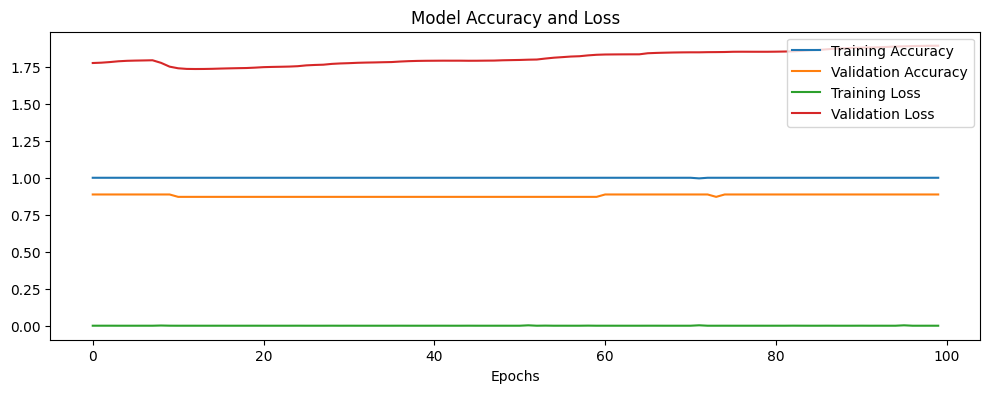

In [12]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_test, y_test))
    
    # Evaluate the model
    evaluate_model(model, X_test, y_test)
    
    # Plot the training history
    plot_history(history)
    plt.show()
    
    # Save the model
    model.save(f'saved_models/gru_model_{epoch}_epochs.h5')  